# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [ ]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import importlib

import audio_functions as af
import audio_models
import dataset

In [28]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

### Get the variables and data ready

In [29]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002

#checkpoint = '52/52-10' #  Best U-net
checkpoint = '159/159-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
mixed_spec, voice_spec, mixed_audio, voice_audio = data.make_one_shot_iterator().get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

mixed_input = mixed_spec[:, :, :-1, 2:4]
voice_input = voice_spec[:, :, :-1, 2:4]

data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [30]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 
                                    'mag_phase', name='Magnitude_Model')
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


In [31]:
model.voice_mask_network.decoder.output.shape

TensorShape([Dimension(None), Dimension(256), Dimension(512), Dimension(2)])

### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [4]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/159/159-8


### Run a batch

In [6]:
mix_inp, mix_phase, voice_inp, voice_est, mask, voice_wave, mix_wave = sess.run([model.mixed_input, 
                                                                                 model.mixed_phase, 
                                                                                 model.voice_input,
                                                                                 model.gen_voice, 
                                                                                 model.voice_mask, 
                                                                                 model.voice_audio, 
                                                                                 model.mixed_audio],
                                                                                {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(voice_est[i, :, :, 1]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)


### Visualise and Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [7]:
i=1
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

5
65280


In [8]:
# Infer the background noise and background noise estimate by subtracting the voice and voice estimate from the mixture
# Normalise audio prior to subtraction
def normalise_audio(audio):
    norm_audio = 2*((audio - audio.min())/(audio.max()-audio.min())) - 1
    return norm_audio

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = normalise_audio(mix_wave[i,:,:])

bg_ref_wave = mix_wave - voice_wave
bg_est_wave = mix_wave - voice_est_wave

In [9]:
# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(len(voice_est_wave)):
    ref_sources.append(np.concatenate((voice_wave[i], bg_ref_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[11.73908457  7.29579654]
 [13.70867384  4.74310211]
 [11.84329206  4.90851823]
 [14.52133012  5.1077251 ]
 [ 4.76884705  5.48611886]] 
SIR
 [[12.33156499 17.88291592]
 [14.23846094 12.08878444]
 [12.50023831 13.9058301 ]
 [15.13889468 12.95880281]
 [ 4.86402906 15.47131458]] 
SAR
 [[20.92979661  7.76292047]
 [23.26835427  5.88809079]
 [20.60775942  5.66644343]
 [23.42849039  6.10011637]
 [22.63501419  6.06683833]] 
NSDR
 [[ 2.93212151 10.99854673]
 [ 1.84430209 16.65686768]
 [ 2.08320967 14.70744424]
 [ 1.94612307 10.11696629]
 [ 0.07365234 10.1249653 ]]


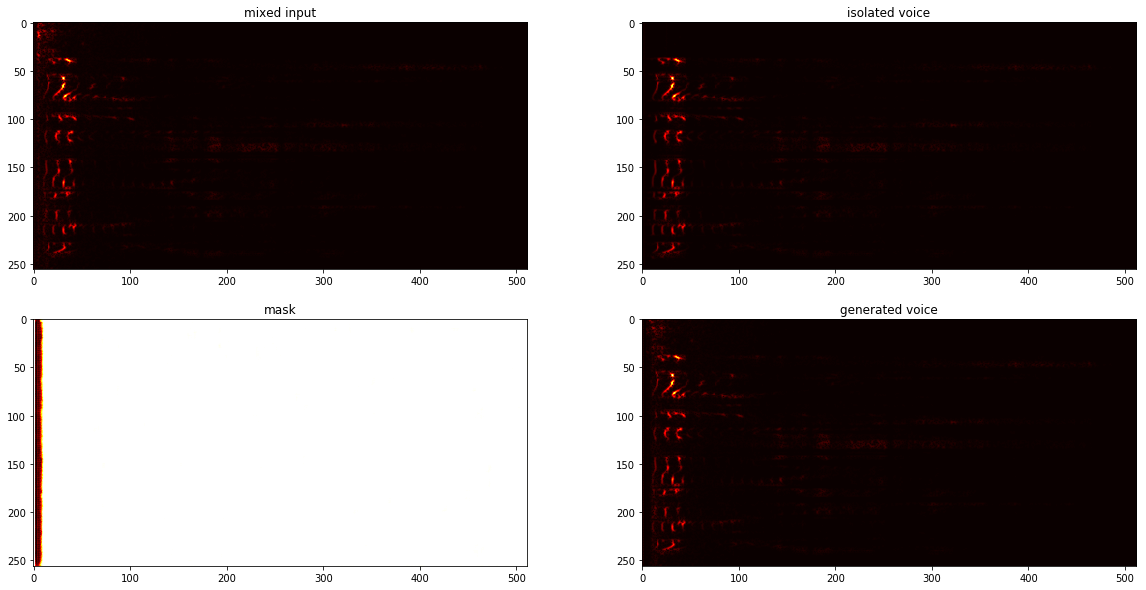

In [15]:
i=0

fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice_inp[i,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(voice_est[i,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

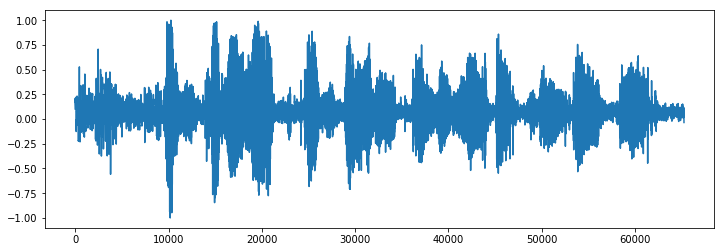

In [16]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

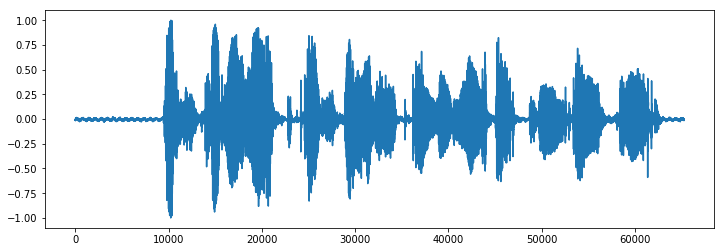

In [17]:
#  The original isolated voice
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

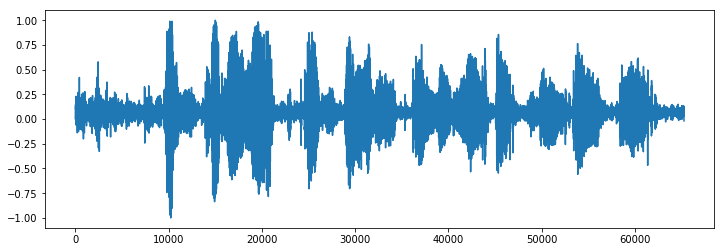

In [18]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

In [ ]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

In [ ]:
#  The background noise, by subtracting the voice on the waveform - doesn't seem to work
#print(metrics['mix'])
plt.figure(figsize=(12,4))
plt.plot(x,bg_ref_wave[i])
ipd.Audio(bg_ref_wave[i].T, rate=sample_rate)

In [ ]:
#  The background noise, by subtracting magnitude spectrograms
plt.figure(figsize=(12,4))
plt.plot(x,bg_est_wave[i])
ipd.Audio(bg_est_wave[i].T, rate=sample_rate)

In [19]:
mask.shape

(5, 256, 512, 1)

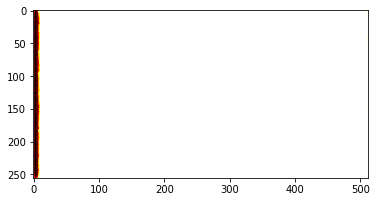

In [22]:
plt.imshow(mask[i,:,:,0])

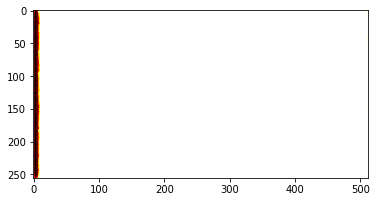

In [21]:
plt.imshow(mask[i,:,:,0])

In [24]:
mask[i,100,:,1]

IndexError: index 1 is out of bounds for axis 3 with size 1